# Product Performance Analysis
## Federico Ariton

In [1]:
import pandas as pd
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="Olist",
    user="postgres",
    password="hadoop",
    port="5432"
)

## Filtering the data

In [3]:
# Updated SQL query with translation join
query = """
SELECT
    t.product_category_name_english AS product_category_name,
    COUNT(oi.product_id) AS total_sales_volume,
    ROUND(SUM(oi.price)::numeric, 2) AS total_revenue,
    ROUND(AVG(CASE WHEN r.review_score IS NOT NULL THEN r.review_score ELSE NULL END)::numeric, 2) AS avg_review_score,
    ROUND(AVG(
        CASE 
            WHEN o.order_delivered_customer_date IS NOT NULL 
                 AND o.order_estimated_delivery_date IS NOT NULL 
            THEN EXTRACT(DAY FROM o.order_delivered_customer_date - o.order_estimated_delivery_date)
            ELSE NULL
        END
    )::numeric, 2) AS avg_delivery_delay
FROM
    olist_order_items oi
JOIN olist_products p ON oi.product_id = p.product_id
JOIN olist_orders o ON oi.order_id = o.order_id
LEFT JOIN olist_order_reviews r ON oi.order_id = r.order_id
LEFT JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name
GROUP BY t.product_category_name_english
ORDER BY total_revenue DESC;
"""

# Load data into DataFrame
df_product_perf = pd.read_sql_query(query, conn)

# Close connection
conn.close()

C:\Users\feder\AppData\Local\Temp\ipykernel_247616\1416842382.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_product_perf = pd.read_sql_query(query, conn)


In [6]:
df_product_perf.head()

,product_category_name,total_sales_volume,total_revenue,avg_review_score,avg_delivery_delay
0,health_beauty,9686,1259744.74,4.14,-11.06
1,watches_gifts,5997,1205256.44,4.02,-11.01
2,bed_bath_table,11202,1045390.52,3.90,-10.74
3,sports_leisure,8667,990729.77,4.11,-11.10
4,computers_accessories,7854,914932.36,3.94,-11.50


## Checkin Missing Values

In [9]:
# Check for missing values
print("Missing values:\n", df_product_perf.isnull().sum())

# Check for duplicates
print("\nDuplicates:", df_product_perf.duplicated().sum())

# Convert column names to snake_case for consistency (optional)
df_product_perf.columns = df_product_perf.columns.str.lower()


Missing values:
 product_category_name    1
total_sales_volume       0
total_revenue            0
avg_review_score         0
avg_delivery_delay       0
dtype: int64

Duplicates: 0


## Exploratory Analysis & Visualization

###  Which product categories generate the most revenue?

C:\Users\feder\AppData\Local\Temp\ipykernel_247616\298125954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_revenue, x='total_revenue', y='product_category_name', palette='Blues_r')


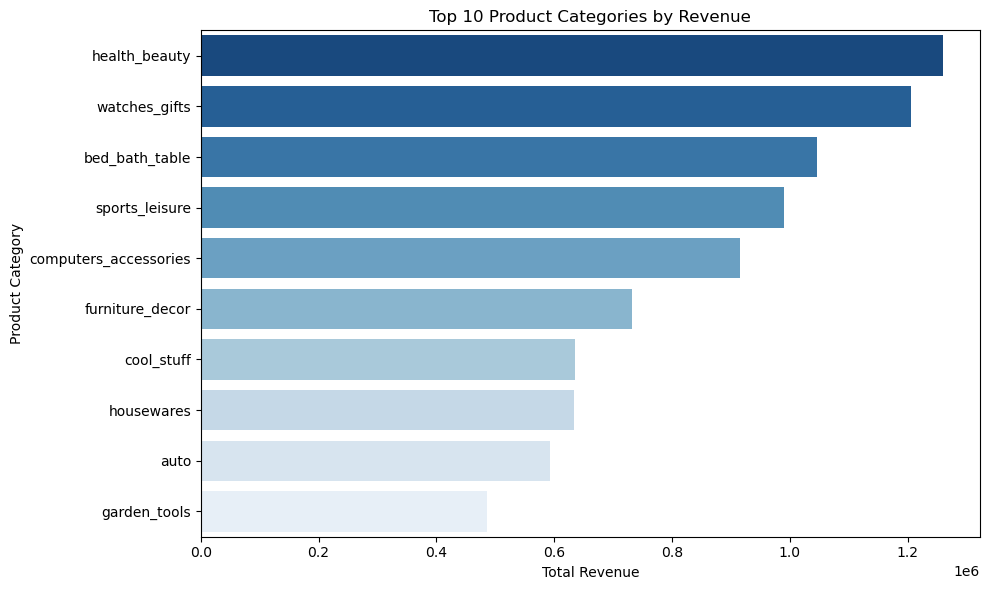

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 categories by revenue
top_revenue = df_product_perf.nlargest(10, 'total_revenue')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_revenue, x='total_revenue', y='product_category_name', palette='Blues_r')
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Which product categories are sold most often (volume)?

C:\Users\feder\AppData\Local\Temp\ipykernel_247616\3270398767.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_volume, x='total_sales_volume', y='product_category_name', palette='Greens_r')


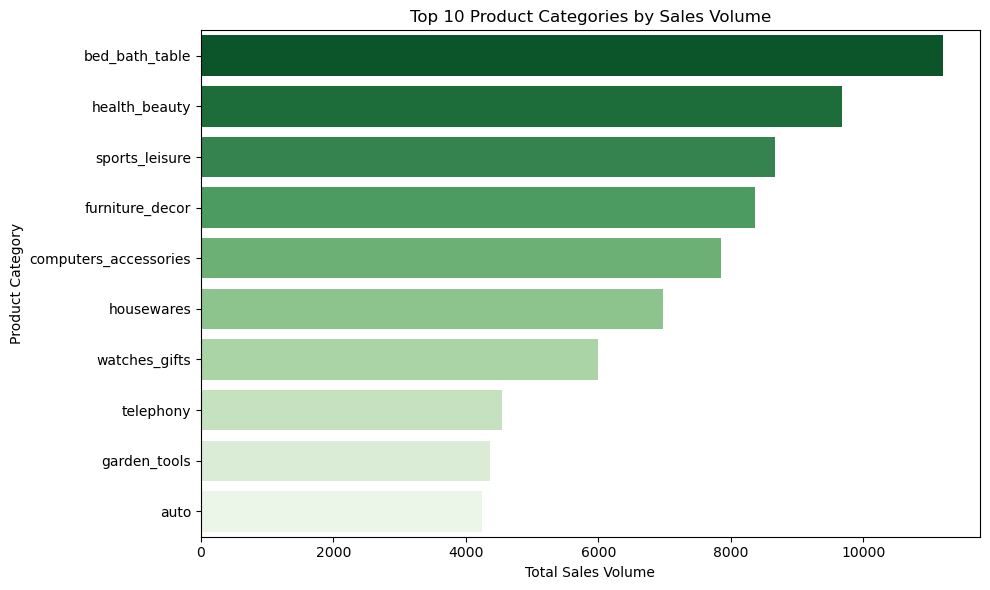

In [15]:
# Top 10 categories by sales volume
top_volume = df_product_perf.nlargest(10, 'total_sales_volume')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_volume, x='total_sales_volume', y='product_category_name', palette='Greens_r')
plt.title("Top 10 Product Categories by Sales Volume")
plt.xlabel("Total Sales Volume")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Which categories are rated best by customers (satisfaction)?

C:\Users\feder\AppData\Local\Temp\ipykernel_247616\1340161173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_reviews, x='avg_review_score', y='product_category_name', palette='Purples_r')


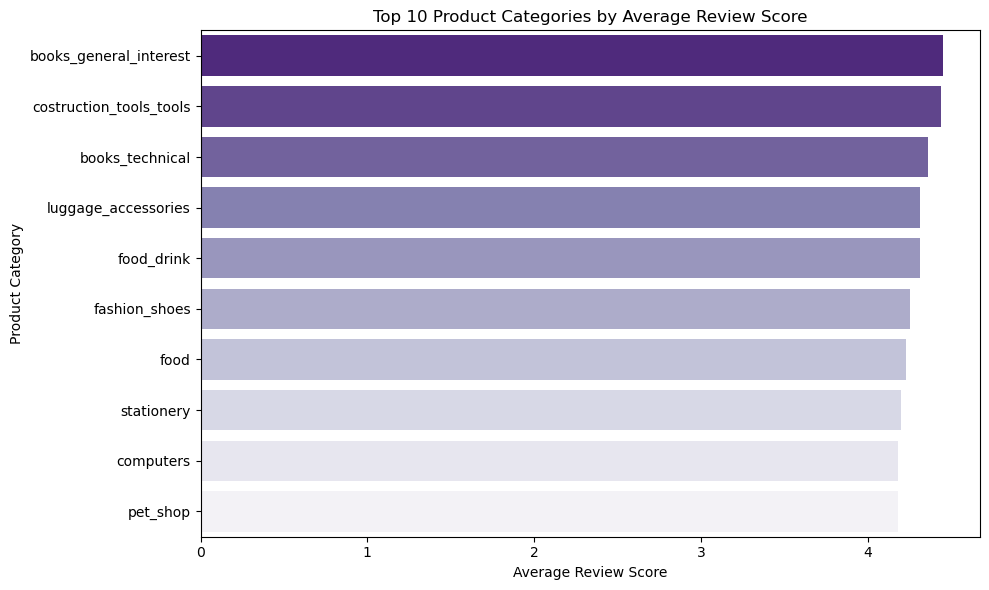

In [17]:
# Top 10 categories by average review score
top_reviews = df_product_perf[df_product_perf['total_sales_volume'] > 100]  # Filter to avoid low-volume noise
top_reviews = top_reviews.nlargest(10, 'avg_review_score')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_reviews, x='avg_review_score', y='product_category_name', palette='Purples_r')
plt.title("Top 10 Product Categories by Average Review Score")
plt.xlabel("Average Review Score")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Are some categories consistently delayed in delivery?

C:\Users\feder\AppData\Local\Temp\ipykernel_247616\2125815129.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_delay, x='avg_delivery_delay', y='product_category_name', palette='Reds_r')


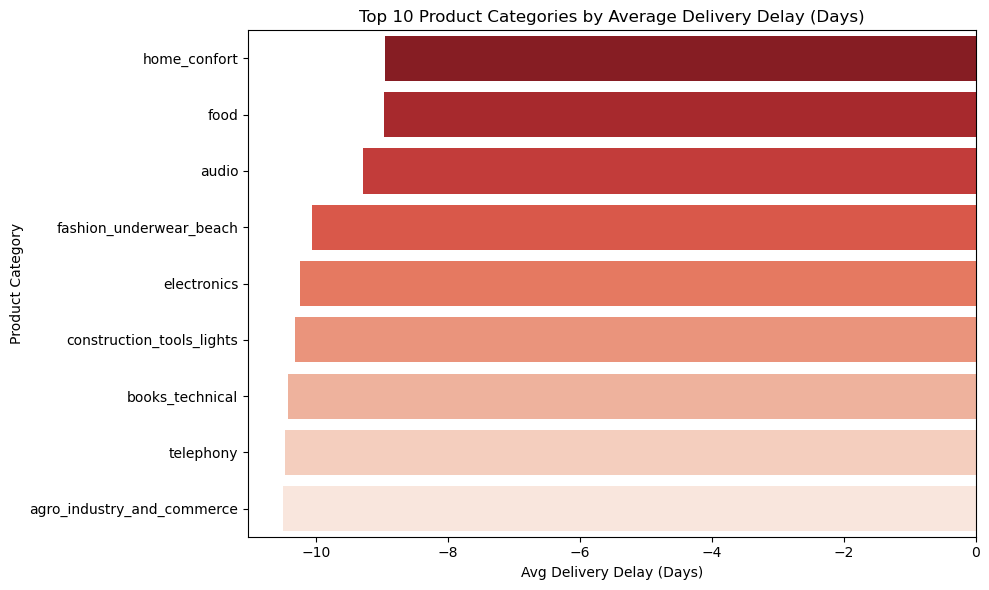

In [22]:
# Top 10 categories by average delivery delay
top_delay = df_product_perf[df_product_perf['total_sales_volume'] > 100]  # Filter low-volume
top_delay = top_delay.nlargest(10, 'avg_delivery_delay')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_delay, x='avg_delivery_delay', y='product_category_name', palette='Reds_r')
plt.title("Top 10 Product Categories by Average Delivery Delay (Days)")
plt.xlabel("Avg Delivery Delay (Days)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Analysis of the Review Score

In [25]:
import psycopg2

# Reconnect to the database
conn = psycopg2.connect(
    host="localhost",
    database="Olist",
    user="postgres",
    password="hadoop",
    port="5432"
)

# Then run your query
query_reviews = """
SELECT review_score, COUNT(*) AS count
FROM olist_order_reviews
GROUP BY review_score
ORDER BY review_score;
"""

df_reviews = pd.read_sql_query(query_reviews, conn)

# Now close the connection again
conn.close()


C:\Users\feder\AppData\Local\Temp\ipykernel_247616\291903531.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_reviews = pd.read_sql_query(query_reviews, conn)


C:\Users\feder\AppData\Local\Temp\ipykernel_247616\2870141741.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_reviews, x="review_score", y="count", palette="rocket")


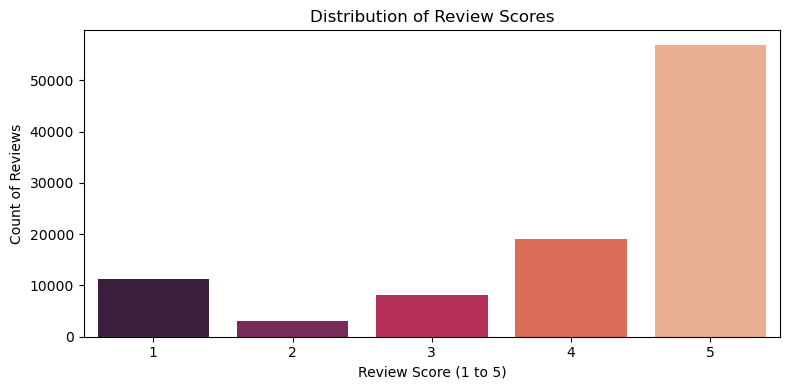

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(data=df_reviews, x="review_score", y="count", palette="rocket")
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score (1 to 5)")
plt.ylabel("Count of Reviews")
plt.tight_layout()
plt.show()


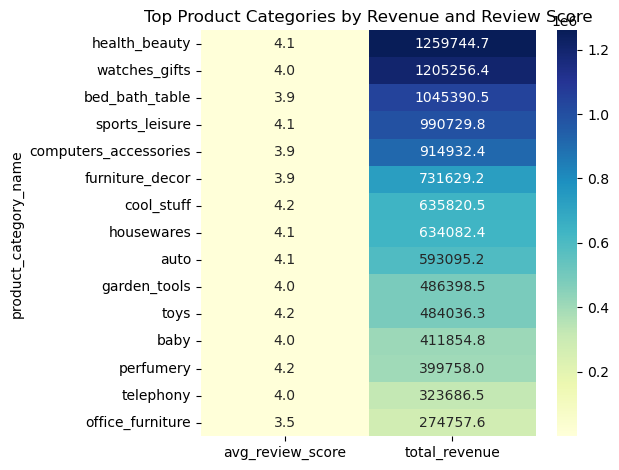

In [29]:
heatmap_data = df_product_perf.pivot_table(
    index='product_category_name',
    values=['total_revenue', 'avg_review_score'],
    aggfunc='mean'
).sort_values(by='total_revenue', ascending=False).head(15)

sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Top Product Categories by Revenue and Review Score")
plt.tight_layout()
plt.show()


In [ ]:
import psycopg2
import pandas as pd
import plotly.express as px

# Step 1: Connect to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="Olist",
    user="postgres",
    password="hadoop",
    port="5432"
)

# Step 2: SQL query
query = """
SELECT
    p.product_category_name,
    COUNT(oi.product_id) AS total_sales_volume,
    SUM(oi.price) AS total_revenue,
    AVG(r.review_score) AS avg_review_score
FROM
    olist_order_items oi
JOIN olist_products p ON oi.product_id = p.product_id
JOIN olist_orders o ON oi.order_id = o.order_id
LEFT JOIN olist_order_reviews r ON oi.order_id = r.order_id
WHERE
    r.review_score IS NOT NULL
GROUP BY
    p.product_category_name
HAVING COUNT(oi.product_id) > 10;
"""

# Step 3: Load data into DataFrame
df = pd.read_sql_query(query, conn)
conn.close()

# Step 4: Segment products
revenue_median = df['total_revenue'].median()
review_median = df['avg_review_score'].median()

def segment(row):
    if row['total_revenue'] >= revenue_median and row['avg_review_score'] >= review_median:
        return '⭐ Star'
    elif row['total_revenue'] >= revenue_median and row['avg_review_score'] < review_median:
        return '🧨 Risky Winner'
    elif row['total_revenue'] < revenue_median and row['avg_review_score'] >= review_median:
        return '🌱 Hidden Gem'
    else:
        return '🧊 Underperformer'

df['segment'] = df.apply(segment, axis=1)

# Step 5: Interactive Plot with Plotly
fig = px.scatter(
    df,
    x="total_revenue",
    y="avg_review_score",
    color="segment",
    hover_name="product_category_name",
    size="total_sales_volume",
    labels={
        "total_revenue": "Total Revenue (R$)",
        "avg_review_score": "Average Review Score",
        "segment": "Product Segment"
    },
    title="🛍️ Interactive Product Segmentation by Revenue & Review Score"
)

fig.update_layout(
    xaxis=dict(title="Total Revenue"),
    yaxis=dict(title="Average Review Score"),
    legend_title="Segment",
    template="plotly_white"
)

fig.show()